# 🥘 Carbonara: Stratigraphic Radiocarbon Calibration Proof-of-Concept

This notebook demonstrates a Bayesian calibration of stratigraphically ordered radiocarbon dates using Python and [PyMC](https://www.pymc.io/). It aims to mimic basic functionality of other radiocarbon calibration software using a minimal domain-specific language (DSL) and probabilistic programming.

The steps include:
1. Defining a stratigraphic model in a readable DSL
2. Loading and interpolating the IntCal20 calibration curve
3. Building and sampling a PyMC model
4. Visualising posterior densities vs. likelihood curves

> This notebook is part of the [Carbonara project](https://github.com/MartinHinz/carbonara_poc), a Python-based open-source initiative for radiocarbon calibration.

## 0. Setup

We begin by importing the required Python libraries for probabilistic modelling (`PyMC`), numerical processing (`NumPy`), data handling (`Pandas`), and plotting (`Matplotlib`). We also use `PyTensor` for low-level tensor operations required by custom interpolation.

In [1]:
from pathlib import Path
import numpy as np, pandas as pd
import pymc as pm, pytensor.tensor as at
import arviz as az
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt


## 1. Mini-DSL: Define your stratigraphic model here
(Very close to known syntax, but in pure Python objects.)

You can define your own stratigraphic model here by combining `R_Date`, `Phase`, and `Sequence` objects.

- `R_Date(name, mean, sigma)` represents an individual radiocarbon date.
- `Phase(name, ...)` groups unordered dates.
- `Sequence(name, ...)` orders phases or dates in top-down stratigraphic order.

In [2]:
class R_Date:
    """Single 14C measurement."""
    def __init__(self, name, mean, sigma):
        self.name    = name
        self.mean    = mean
        self.sigma   = sigma
        self.var     = None  # to be set to the PyMC variable

class Phase:
    """Unordered group of R_Date objects."""
    def __init__(self, name, *dates):
        self.name    = name
        self.dates   = list(dates)

class Sequence:
    """Ordered list: first any top-level R_Dates, then Phases in sequence."""
    def __init__(self, name, *children):
        self.name     = name
        self.children = children
        # split out any standalone R_Dates before the first Phase:
        self.top_dates = [c for c in children if isinstance(c, R_Date)]
        self.phases    = [c for c in children if isinstance(c, Phase)]

Below is an example with two phases, each containing multiple dates.

In [3]:
# your model:
MODEL = Sequence("TestSeq",
    Phase("Layer1",
        R_Date("D1", 5000, 25),
        R_Date("D2", 4920, 25),
        R_Date("D6", 4940, 25),
    ),
    Phase("Layer2",
        R_Date("D3", 4970, 25),
        R_Date("D4", 4855, 25),
        R_Date("D5", 4930, 25),
         ),
)

## 2. Load IntCal20 and Set Up Interpolation

To calibrate radiocarbon dates, we need to map each possible calendar age (in years **Before Present**, or **Cal BP**) to its expected radiocarbon age and associated uncertainty. This mapping is provided by the **IntCal20 calibration curve** (Reimer et al. 2020), which we load from a CSV file.

We then prepare a **linear interpolation function** in PyTensor (used by PyMC) that allows us to compute:

- The expected radiocarbon age (`C14Age`)
- The calibration curve uncertainty (`C14Age.sigma`)

...for any given calendar age. This is necessary because calibration curves are tabulated at irregular intervals, while our model requires continuous functions to evaluate the likelihood of each sample’s observed radiocarbon age.

In [4]:
# load curve
cal = pd.read_csv(Path("..") / "data" / "intcal20.14c", comment="#", header=None,
                  names=["CalBP","C14Age","C14Age.sigma","Δ14C","ΔΣ"])
cal = cal.sort_values("CalBP").reset_index(drop=True)
cal_bp  = cal["CalBP"].values
age     = cal["C14Age"].values
age_sig = cal["C14Age.sigma"].values

# tensor versions
cal_bp_tt    = at.as_tensor_variable(cal_bp)
age_tt       = at.as_tensor_variable(age)
age_sig_tt   = at.as_tensor_variable(age_sig)

def interp(x, xp, fp):
    idx = at.clip(at.searchsorted(xp, x, side="right") - 1,
                  0, xp.shape[0]-2)
    x0, x1 = xp[idx], xp[idx+1]
    y0, y1 = fp[idx], fp[idx+1]
    return y0 + (y1-y0)*(x-x0)/(x1-x0)

## 3. Build & Sample the PyMC Model

We now construct the Bayesian model using [PyMC](https://www.pymc.io/) with the following assumptions:

- Each radiocarbon date corresponds to an unknown calendar age, modelled as a Uniform prior between the limits of the calibration curve.
- The expected radiocarbon age is obtained by interpolating the IntCal20 calibration curve at that calendar age.
- The total uncertainty combines the measurement error of the date with the calibration curve uncertainty (added in quadrature).
- Stratigraphic ordering is enforced using hard constraints: dates in lower layers must be older than those above.

We use **Metropolis sampling** rather than NUTS because of the hard discontinuities introduced by the ordering constraints, which are not well-handled by gradient-based samplers.

The resulting posterior distributions represent the calibrated age ranges for each sample, respecting both measurement uncertainty and stratigraphic logic.

In [5]:
def collect_dates(seq):
    """Flatten Sequence → [R_Date,...] in order."""
    out = []
    out.extend(seq.top_dates)
    for ph in seq.phases:
        out.extend(ph.dates)
    return out

def apply_ordering(seq, penalty=-1e6):
    """
    For Sequence seq, build groups = [top_dates] + [each phase.r_dates].
    Then for each adjacent pair (A,B) we add
      0 penalty if every a in A is > every b in B,
      -inf otherwise.
    """
    groups = [seq.top_dates] + [ph.dates for ph in seq.phases]
    for k, (A, B) in enumerate(zip(groups, groups[1:])):
        if not A or not B:
            continue
        for i, da in enumerate(A):
            for j, db in enumerate(B):
                pot_name = f"{seq.name}_grp{k}_i{i}_j{j}"
                pm.Potential(
                    pot_name,
                    at.switch(da.var > db.var, 0.0, -np.inf)
                )



We now define a probabilistic model where each `R_Date` is assigned a calendar age variable. The calibration curve is used to derive the expected radiocarbon age and uncertainty. Stratigraphic ordering is enforced using hard constraints between phases.

We use Metropolis sampling to estimate the posterior calendar ages. TODO: NUTS is not working due to discontinuity from ordering constraints. This can be improved.

In [6]:
# build & sample
with pm.Model() as model:
    dates = collect_dates(MODEL)
    # 1) define variables + likelihoods
    for i, d in enumerate(dates):
        d.var = pm.Uniform(f"age_{i}",
                          lower=cal_bp.min(),
                          upper=cal_bp.max())
        mu    = interp(d.var, cal_bp_tt, age_tt)
        scurv = interp(d.var, cal_bp_tt, age_sig_tt)
        totσ  = at.sqrt(d.sigma**2 + scurv**2)
        pm.Normal(f"obs_{i}", mu=mu, sigma=totσ, observed=d.mean)

    # 2) stratigraphic ordering
    apply_ordering(MODEL)

    # 3) smart init: sort mean ages descending
    means      = np.array([d.mean for d in dates])
    init_order = np.sort(means)[::-1]
    init_vals  = {f"age_{i}": init_order[i] - i*1e-3
                  for i in range(len(dates))}

    trace = pm.sample(20_000, tune=5_000,
                      step=pm.Metropolis(),
                      chains=4, cores=4,
                      initvals=init_vals,
                      return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [age_0]
>Metropolis: [age_1]
>Metropolis: [age_2]
>Metropolis: [age_3]
>Metropolis: [age_4]
>Metropolis: [age_5]


/Users/martin/.local/pipx/venvs/jupyterlab/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 8 seconds.


## 4. Visualise Posterior Distributions vs. Likelihoods

The plot below compares the **posterior distributions** of the calibrated calendar ages (inferred via PyMC) with their corresponding **raw radiocarbon likelihoods**.

- The **dashed black lines** represent the likelihood functions derived from the observed radiocarbon dates, assuming no stratigraphic ordering.
- The **coloured shaded curves** represent the calibrated posterior distributions, which incorporate:
  - the non-linear calibration curve (IntCal20),
  - the measurement uncertainties,
  - and any **stratigraphic ordering constraints** imposed in the model.

Each distribution is vertically stacked and aligned with the corresponding sample name. This visualisation highlights how the raw likelihoods are transformed by the Bayesian calibration process, including the narrowing or shifting of ranges due to stratigraphic priors.

> This kind of plot is useful for understanding the interplay between radiocarbon measurement, calibration curve structure, and archaeological context.

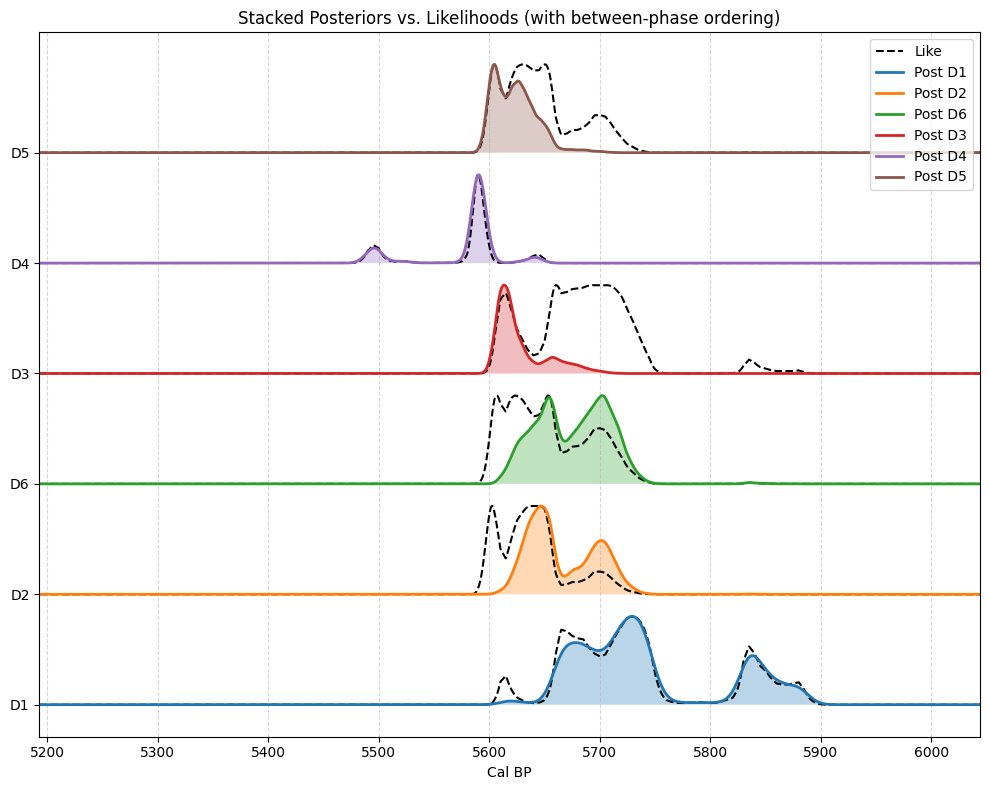

In [7]:
names    = [d.name for d in dates]
posts    = [trace.posterior[f"age_{i}"].values.flatten()
            for i in range(len(dates))]

# combined HDI
allv      = np.concatenate(posts)
lo, hi    = az.hdi(allv, prob=0.95)
xs        = np.linspace(lo-300, hi+300, 2000)

# raw likelihoods
lks = []
for d in dates:
    mu_p  = np.interp(xs, cal_bp, age)
    totσ  = np.sqrt(d.sigma**2 +
                    np.interp(xs, cal_bp, age_sig)**2)
    lk    = np.exp(-0.5*((mu_p-d.mean)/totσ)**2)
    lk   /= np.trapezoid(lk, xs)
    lks.append(lk)

plt.figure(figsize=(10,8))
for i,(n,post,lk) in enumerate(zip(names,posts,lks)):
    base = i
    # likelihood
    plt.plot(xs, base + lk/lk.max()*0.8, 'k--',
             label="Like" if i==0 else None)
    # posterior
    try:
        dens = gaussian_kde(post)(xs)
        dens = dens/dens.max()*0.8
        plt.fill_between(xs, base, base+dens, alpha=0.3)
        plt.plot(xs, base+dens, lw=2, label=f"Post {n}")
    except:
        xm = np.median(post)
        plt.vlines(xm, base, base+0.8, lw=3, label=f"Post {n}")

plt.yticks(range(len(names)), names)
plt.xlim(xs[0], xs[-1])
plt.xlabel("Cal BP")
plt.title("Stacked Posteriors vs. Likelihoods (with between-phase ordering)")
plt.legend(loc="upper right")
plt.grid(axis='x', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 5. Summary of Posterior Estimates

Below is a summary of the calibrated calendar ages for each sample:

- **Median**: the central tendency of the posterior distribution
- **95% HDI (Highest Density Interval)**: the narrowest range containing 95% of the posterior probability mass
- These summaries take into account both the raw radiocarbon data and the stratigraphic constraints

This output provides an readable overview of the estimated ages and their uncertainties.

In [8]:
for i, d in enumerate(dates):
    var = trace.posterior[f"age_{i}"]
    median = np.median(var.values)

    # HDI returns a Dataset with dimensions: chain, draw, hdi
    hdi = az.hdi(var, hdi_prob=0.95)

    # Collapse chain and draw, then access values directly
    lo = hdi[f"age_{i}"].sel(hdi="lower").values.mean()
    hi = hdi[f"age_{i}"].sel(hdi="higher").values.mean()

    print(f"{d.name}: median = {int(round(median))}, 95% HDI = [{int(round(lo))}, {int(round(hi))}]")

D1: median = 5725, 95% HDI = [5656, 5876]
D2: median = 5655, 95% HDI = [5620, 5721]
D6: median = 5678, 95% HDI = [5619, 5727]
D3: median = 5619, 95% HDI = [5600, 5681]
D4: median = 5590, 95% HDI = [5484, 5634]
D5: median = 5622, 95% HDI = [5593, 5657]


## 🧭 Next Steps

- Generalise the DSL for more OxCal features (e.g. boundaries, gaps, prior shapes)
- Switch to NUTS if ordering can be softened or relaxed
- Package `R_Date`, `Phase`, and `Sequence` into reusable modules (`src/`)
- Validate against known calibration program outputs

Feel free to contribute via [GitHub](https://github.com/MartinHinz/carbonara_poc)!

## 🧪 Try It Yourself

To experiment with your own stratigraphic model:

1. Modify the `MODEL = Sequence(...)` block above.
2. Change or add `R_Date(...)` entries, group them into `Phase(...)` objects.
3. Re-run the notebook from top to bottom to see how your model behaves.

Feel free to fork this notebook and adapt it to your own use case!